In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd
from tqdm import tqdm

In [2]:
# Use the TensorFlow method to download and/or load the data.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
ed.set_seed(314159)
N = 100   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

In [4]:
# define the feedforward neural network function

def neural_network(x, W_0, W_1, b_0, b_1):
  h = tf.tanh(tf.matmul(x, W_0) + b_0)
  h = tf.matmul(h, W_1) + b_1
  return h #tf.reshape(h, [-1])

In [5]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [N, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
W_0 = Normal(loc=tf.zeros([D, 20]), scale=tf.ones([D, 20]))
W_1 = Normal(loc=tf.zeros([20, 10]), scale=tf.ones([20, 10]))
b_0 = Normal(loc=tf.zeros(20), scale=tf.ones(20))
b_1 = Normal(loc=tf.zeros(10), scale=tf.ones(10))
# Categorical likelihood for classication.
y = Categorical(neural_network(x, W_0, W_1, b_0, b_1))

In [8]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, 20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, 20]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([20, 10])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20, 10]))))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([10])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([10]))))

In [23]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({W_0: qW_0, W_1: qW_1,
                     b_0: qb_0, b_1: qb_1}, data={y:y_ph})

In [24]:
# Initialise the inference variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(mnist.train.num_examples) / N})

In [14]:
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

In [15]:
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ ETA: 19042s | Loss: 470617.3 ETA: 207s | Loss: 118471.695 ETA: 110s | Loss: 59833.680 ETA: 77s | Loss: 70502.14 ETA: 61s | Loss: 39749.0 ETA: 50s | Loss: 49798.0 ETA: 43s | Loss: 44190.3 ETA: 38s | Loss: 37677.0 ETA: 34s | Loss: 39922.6 ETA: 31s | Loss: 49659.2 ETA: 28s | Loss: 36020.6 ETA: 26s | Loss: 33289.5 ETA: 25s | Loss: 46891.7 ETA: 23s | Loss: 28452.3 ETA: 22s | Loss: 35076.2 ETA: 21s | Loss: 27717.3 ETA: 20s | Loss: 29689.6 ETA: 19s | Loss: 28850.4 ETA: 18s | Loss: 29739.4 ETA: 17s | Loss: 39811.7 ETA: 16s | Loss: 34898.7 ETA: 15s | Loss: 39067.6 ETA: 14s | Loss: 35874.4 ETA: 13s | Loss: 30441.3 ETA: 13s | Loss: 34483.6 ETA: 12s | Loss: 29741.7 ETA: 11s | Loss: 25218.1 ETA: 11s | Loss: 33166.4 ETA: 10s | Loss: 40767.5 ETA: 10s | Loss: 37403.5 ETA: 9s | Loss: 36030.520 ETA: 8s | Loss: 27315.94 ETA: 8s | Loss: 41885.35 ETA: 7s | Loss: 24480.43 ETA: 7s | Loss: 24983.28 ETA: 6s | Loss: 28468.79 ETA: 6s | Loss: 33554.02 ETA: 5s | Loss

In [16]:
Y_batch.shape

(100,)

## Evaluating the model

In [17]:
# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

In [18]:
# Generate samples the posterior and store them.
n_samples = 10
prob_lst = []
samples = []
w_0_samples = []
b_0_samples = []
w_1_samples = []
b_1_samples = []

for _ in tqdm(range(n_samples)):
    w0_samp = qW_0.sample()
    b0_samp = qb_0.sample()
    w1_samp = qW_1.sample()
    b1_samp = qb_1.sample()

    w_0_samples.append(w0_samp)
    b_0_samples.append(b0_samp)
    w_1_samples.append(w1_samp)
    b_1_samples.append(b1_samp)

    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(neural_network(X_test, w0_samp, w1_samp, b0_samp, b1_samp))
    #prob = tf.nn.softmax(tf.matmul( X_test,w_samp ) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w0_samp,[-1]),b0_samp],0)
    samples.append(sample.eval())

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.05s/it]


In [28]:
prob

<tf.Tensor 'Softmax_9:0' shape=(10000, 10) dtype=float32>

In [29]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

accuracy in predicting the test data =  91.81


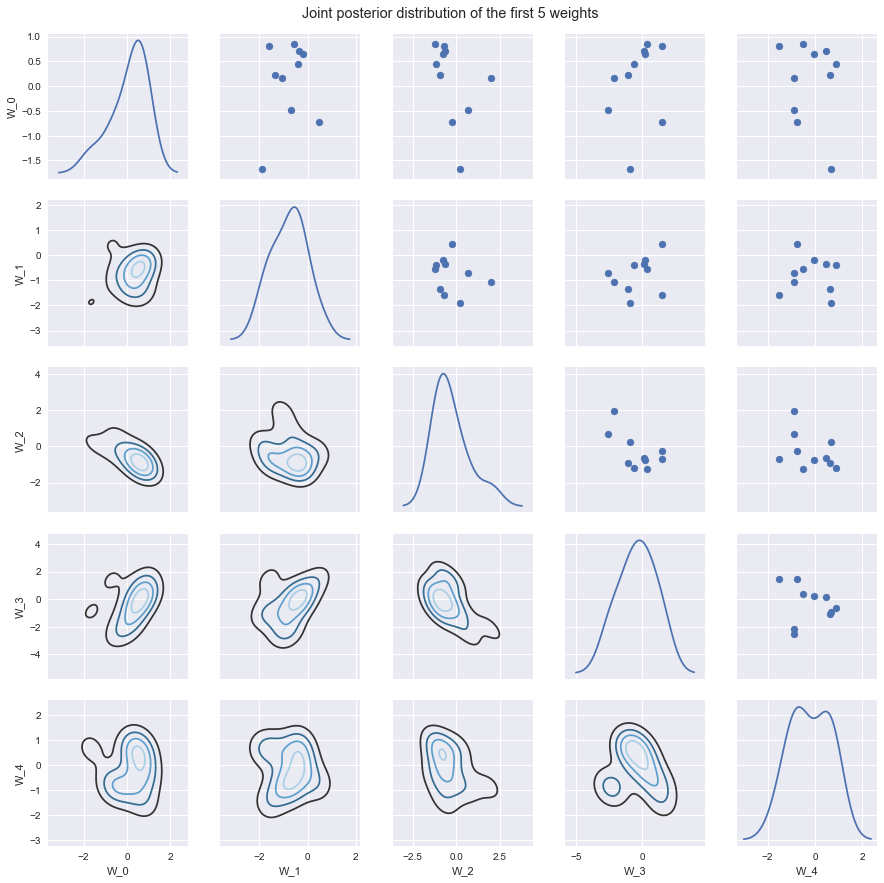

In [30]:
# Create a Pandas DataFrame of posterior samples.
samples_df = pd.DataFrame(data = samples, index=range(n_samples))
# Now create a small subset by taking the first 5 weights, labelled as W_0, ... , W_4.
samples_5 = pd.DataFrame(data = samples_df[list(range(5))].values,columns=["W_0", "W_1", "W_2", "W_3", "W_4"])
# We use Seaborn PairGrid to make a triale plot to show auto and cross correlations.
g = sns.PairGrid(samples_5, diag_sharey=False)
g.map_lower(sns.kdeplot, n_levels = 4,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,legend=False)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Joint posterior distribution of the first 5 weights')

truth =  2


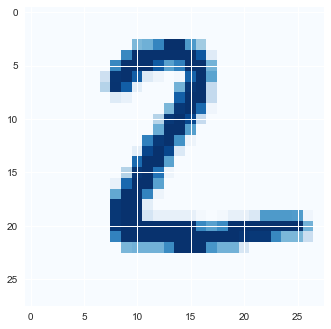

In [31]:
# Load the first image from the test data and its label.
test_image = X_test[1:2]
test_label = Y_test[1]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')

In [ ]:
# Now the check what the model perdicts for each (w,b) sample from the posterior. This may take a few seconds...
sing_img_probs = []
n_samples = 100
for _ in tqdm(range(n_samples)):
    
    w0_samp = qW_0.sample()
    b0_samp = qb_0.sample()
    w1_samp = qW_1.sample()
    b1_samp = qb_1.sample()
    
    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(neural_network(X_test[1:2], w0_samp, w1_samp, b0_samp, b1_samp))
    sing_img_probs.append(prob.eval())

In [ ]:
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test digit")
plt.ylabel("Frequency")

In [ ]:
## how does the model handle unfamiliar data ?

In [ ]:
prob = tf.nn.softmax(neural_network(X_test, w0_samp, w1_samp, b0_samp, b1_samp))

In [ ]:
a = prob.eval()

In [ ]:
np.argmax(a[1])

In [27]:
qW_0.eval().shape

(784, 20)